In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import holidays
from tqdm.notebook import tqdm

# 1.0 Import Data

In [3]:
# Import ridership data
data_dir = '/content/drive/My Drive/MIE498 Thesis/0_Data'
merged_bike_data_2019 = pd.read_csv("{}/ridership_2019_with_bike_stations_info_20200930.csv".format(data_dir), header=0)
print(merged_bike_data_2019.shape)
merged_bike_data_2019['End Day of Year'] = merged_bike_data_2019.apply(lambda row: datetime.strptime(row['End Time'], "%Y-%m-%d %H:%M:%S").timetuple().tm_yday, axis=1)
print(merged_bike_data_2019.shape)
merged_bike_data_2019.head()

(2438720, 26)
(2438720, 27)


,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type,Bike Id,Start Year,Start Month,Start Hour,Start Day of Week,Start Holiday,End Year,End Month,End Hour,End Day of Week,End Holiday,Start Day of Year,Start Week of Year,Start Lat,Start Lon,End Lat,End Lon,End Day of Year
0,4581278.0,1547.0,7021.0,2019-01-01 00:08:00,Bay St / Albert St,7233.0,2019-01-01 00:33:00,King / Cowan Ave - SMART,Annual Member,1296.0,2019.0,1.0,0.0,1.0,1.0,2019.0,1.0,0.0,1.0,1.0,1.0,1.0,43.653264,-79.382458,43.637922,-79.431734,1
1,4586979.0,1243.0,7021.0,2019-01-03 17:13:00,Bay St / Albert St,7233.0,2019-01-03 17:34:00,King / Cowan Ave - SMART,Annual Member,3168.0,2019.0,1.0,17.0,3.0,0.0,2019.0,1.0,17.0,3.0,0.0,3.0,1.0,43.653264,-79.382458,43.637922,-79.431734,3
2,4591641.0,1112.0,7021.0,2019-01-04 21:42:00,Bay St / Albert St,7233.0,2019-01-04 22:00:00,King / Cowan Ave - SMART,Annual Member,3512.0,2019.0,1.0,21.0,4.0,0.0,2019.0,1.0,22.0,4.0,0.0,4.0,1.0,43.653264,-79.382458,43.637922,-79.431734,4
3,4594328.0,1156.0,7021.0,2019-01-05 23:21:00,Bay St / Albert St,7233.0,2019-01-05 23:40:00,King / Cowan Ave - SMART,Annual Member,212.0,2019.0,1.0,23.0,5.0,0.0,2019.0,1.0,23.0,5.0,0.0,5.0,1.0,43.653264,-79.382458,43.637922,-79.431734,5
4,4596322.0,1068.0,7021.0,2019-01-06 21:42:00,Bay St / Albert St,7233.0,2019-01-06 22:00:00,King / Cowan Ave - SMART,Annual Member,3279.0,2019.0,1.0,21.0,6.0,0.0,2019.0,1.0,22.0,6.0,0.0,6.0,1.0,43.653264,-79.382458,43.637922,-79.431734,6


In [4]:
# Read station-neighbourhood mapping
df_station_assignments = pd.read_csv("{}/station_assignment.csv".format(data_dir), header=0, encoding='ISO-8859-1')
print(df_station_assignments.shape)
print(df_station_assignments.columns)
df_station_assignments.head()

(464, 7)
Index(['station_id', 'station_na', 'lat', 'lon', 'neighborhood_id', 'FSA_code',
       'da_id'],
      dtype='object')


,station_id,station_na,lat,lon,neighborhood_id,FSA_code,da_id
0,7021,Bay St / Albert St,43.653264,-79.382458,76,M5G,35204616.0
1,7160,King St W / Tecumseth St,43.643333,-79.405556,82,M5V,35204142.0
2,7012,Elizabeth St / Edward St (Bus Terminal),43.656026,-79.385327,76,M5G,35204607.0
3,7041,Edward St / Yonge St,43.656729,-79.382736,76,M5G,35204608.0
4,7275,Queen St W / James St,43.652276,-79.380701,76,M5G,35204616.0


In [5]:
station_fsa_dict = pd.Series(df_station_assignments['FSA_code'].values, index=df_station_assignments['station_id']).to_dict()
merged_data = merged_bike_data_2019.copy()
merged_data['Start Forward_Sortation_Area'] = merged_bike_data_2019.apply(lambda row: station_fsa_dict[int(row['Start Station Id'])], axis=1)
merged_data['End Forward_Sortation_Area'] = merged_bike_data_2019.apply(lambda row: station_fsa_dict[int(row['End Station Id'])], axis=1)

In [6]:
print(merged_data.shape)
merged_data.head()

(2438720, 29)


,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type,Bike Id,Start Year,Start Month,Start Hour,Start Day of Week,Start Holiday,End Year,End Month,End Hour,End Day of Week,End Holiday,Start Day of Year,Start Week of Year,Start Lat,Start Lon,End Lat,End Lon,End Day of Year,Start Forward_Sortation_Area,End Forward_Sortation_Area
0,4581278.0,1547.0,7021.0,2019-01-01 00:08:00,Bay St / Albert St,7233.0,2019-01-01 00:33:00,King / Cowan Ave - SMART,Annual Member,1296.0,2019.0,1.0,0.0,1.0,1.0,2019.0,1.0,0.0,1.0,1.0,1.0,1.0,43.653264,-79.382458,43.637922,-79.431734,1,M5G,M6K
1,4586979.0,1243.0,7021.0,2019-01-03 17:13:00,Bay St / Albert St,7233.0,2019-01-03 17:34:00,King / Cowan Ave - SMART,Annual Member,3168.0,2019.0,1.0,17.0,3.0,0.0,2019.0,1.0,17.0,3.0,0.0,3.0,1.0,43.653264,-79.382458,43.637922,-79.431734,3,M5G,M6K
2,4591641.0,1112.0,7021.0,2019-01-04 21:42:00,Bay St / Albert St,7233.0,2019-01-04 22:00:00,King / Cowan Ave - SMART,Annual Member,3512.0,2019.0,1.0,21.0,4.0,0.0,2019.0,1.0,22.0,4.0,0.0,4.0,1.0,43.653264,-79.382458,43.637922,-79.431734,4,M5G,M6K
3,4594328.0,1156.0,7021.0,2019-01-05 23:21:00,Bay St / Albert St,7233.0,2019-01-05 23:40:00,King / Cowan Ave - SMART,Annual Member,212.0,2019.0,1.0,23.0,5.0,0.0,2019.0,1.0,23.0,5.0,0.0,5.0,1.0,43.653264,-79.382458,43.637922,-79.431734,5,M5G,M6K
4,4596322.0,1068.0,7021.0,2019-01-06 21:42:00,Bay St / Albert St,7233.0,2019-01-06 22:00:00,King / Cowan Ave - SMART,Annual Member,3279.0,2019.0,1.0,21.0,6.0,0.0,2019.0,1.0,22.0,6.0,0.0,6.0,1.0,43.653264,-79.382458,43.637922,-79.431734,6,M5G,M6K


In [7]:
merged_data.isnull().sum()

Trip Id                         0
Trip Duration                   0
Start Station Id                0
Start Time                      0
Start Station Name              0
End Station Id                  0
End Time                        0
End Station Name                0
User Type                       0
Bike Id                         0
Start Year                      0
Start Month                     0
Start Hour                      0
Start Day of Week               0
Start Holiday                   0
End Year                        0
End Month                       0
End Hour                        0
End Day of Week                 0
End Holiday                     0
Start Day of Year               0
Start Week of Year              0
Start Lat                       0
Start Lon                       0
End Lat                         0
End Lon                         0
End Day of Year                 0
Start Forward_Sortation_Area    0
End Forward_Sortation_Area      0
dtype: int64

# 2.0 Bipartite Clustering Algorithm Implementation

In [8]:
print('Number of postal codes:', len(np.unique(merged_data['Start Forward_Sortation_Area'])))
print('Number of stations:', len(np.unique(merged_data['Start Station Id'])))

Number of postal codes: 38
Number of stations: 464


In [9]:
# Training: Months 1-9, Testing: Months 10-12
training_data = merged_data.loc[(merged_data['Start Month'] >= 1) & (merged_data['Start Month'] <= 9)]
testing_data = merged_data.loc[(merged_data['Start Month'] >= 10) & (merged_data['Start Month'] <= 12)]

In [10]:
print(merged_data.shape, training_data.shape, testing_data.shape)

(2438720, 29) (1970776, 29) (467944, 29)


In [11]:
merged_data.columns

Index(['Trip Id', 'Trip Duration', 'Start Station Id', 'Start Time',
       'Start Station Name', 'End Station Id', 'End Time', 'End Station Name',
       'User Type', 'Bike Id', 'Start Year', 'Start Month', 'Start Hour',
       'Start Day of Week', 'Start Holiday', 'End Year', 'End Month',
       'End Hour', 'End Day of Week', 'End Holiday', 'Start Day of Year',
       'Start Week of Year', 'Start Lat', 'Start Lon', 'End Lat', 'End Lon',
       'End Day of Year', 'Start Forward_Sortation_Area',
       'End Forward_Sortation_Area'],
      dtype='object')

## 2.1 Function Definitions

### 2.1.1 Plot Clusters and Points

In [12]:
def plot_clusters():
  fig = plt.figure(figsize=(7,7))  
  # Plot points in the clusters
  _cluster = list(df_station_assignments.groupby('cluster').groups.values())
  for c in _cluster:
    plt.scatter(df_station_assignments.loc[c]['lon'], df_station_assignments.loc[c]['lat'])
  plt.show()

### 2.1.2 Calculate Time Slot and Probabilities of Start Station checking into Cluster j

In [13]:
def calc_slot(raw_date_str):
  dt = datetime.strptime(raw_date_str, '%Y-%m-%d %H:%M:%S') #2019-01-01 00:08:00
  weekday = dt.weekday()
  hr = dt.hour

  holidays_can_on = list(holidays.CA(years=2019, prov='ON').keys())
  holiday = check_holidays(dt, holidays_can_on)
  
  # Weekdays
  if weekday <= 4 and holiday == 0:
      if hr >= 7:
        if hr <= 10:
          return 0 # Weekday Morning
        if hr <= 14:
          return 1 # Weekday Day Hours
        if hr <= 19:
          return 2 # Weekday Evening
      return 3 # Weekday Night Hours
  
  # Weekend/Holidays
  elif weekday >= 5 or holiday == 1:
    if hr >= 7:
      if hr <= 10:
        return 4 # Weekend/Holidays Morning
      if hr <= 14:
        return 5 # Weekend/Holidayss Day Hours
      if hr <= 19:
        return 6 # Weekend/Holidays Evening
    return 7 # Weekend/Holidays Night Hours

In [14]:
def check_holidays(date, holidays_can_on):
  if date in holidays_can_on: 
    return 1
  else: 
    return 0

### 2.1.3 Check if the clusters converge

In [15]:
def checkSameCluster(s, s0):
  station_ids_list = list(s['station_id'].unique())
  nStations = len(station_ids_list)
  df = pd.DataFrame(np.zeros((nStations, nStations))).astype(int)
  df.columns = station_ids_list
  df.index = station_ids_list
  for station in station_ids_list:
    cluster_a = int(s[s['station_id'] == station]['cluster'])
    cluster_b = int(s0[s0['station_id'] == station]['cluster'])
    if cluster_a == cluster_b:
      df.at[station, station] = 1
  # print(df)
  df2 = pd.DataFrame(np.eye(nStations, dtype=int))
  similarity_score = np.multiply(df, df2).sum().sum()
  # print(np.multiply(df, df2))

  if similarity_score == nStations:
    return True 
  else:
    print(nStations, similarity_score)
    return False

## 2.2 Main Bipartite Clustering Algorithm Function

In [16]:
# Referenced some code from: https://github.com/hongziqi/Traffic-Prediction
def bipartite_clustering(ridership_data, station_data, K2, W):
  n = len(station_data)
  K1 = len(np.unique(station_data['FSA_code']))  # Number of FSAs
  
  # Initial K-Means Clustering - based on station's geographical locations
  X = np.array(station_data[['lat', 'lon']])
  # print(X.shape)
  station_data['cluster'] = KMeans(n_clusters=K1).fit(X).labels_

  # Initialize iteration
  w = 0
  
  def get_t_vector(station_id):
      # Retrieve the dataframe with the selected start station 
      df_station = df_bc[df_bc['Start Station Id'] == station_id]
      # Specify the row in which the trip belongs to (based on start time)
      df_station['Time Slot'] =  df_station['Start Time'].map(calc_slot)
      # Group by the 8 time slots (8 rows in transition matrix), save in a dictionary
      timeslot_to_stationids = dict(df_station.groupby('Time Slot').groups)  # key=slot : value=row indices

      for key in timeslot_to_stationids.keys():
        # Compute number of rows in each cluster and save in a dictionary (key=cluster# : value=#ofrows)
        ndict = dict(df_station.loc[timeslot_to_stationids[key]].groupby('cluster').size())
        # Get the list of number of rows counts, saved in np.array
        count = np.array(list(map(lambda x: ndict[x] if x in ndict else 0, range(K1))))
        # Calculate the probabilities
        count = count / count.sum()
        # Update the dictionary
        timeslot_to_stationids[key] = count
      
      # If the data doesn't contain information for all time slots
      if len(timeslot_to_stationids) < 8:
        # Compute the mean values of each column in the updated timeslot_to_stationids
        mean = np.array(list(timeslot_to_stationids.values())).mean(axis=0)
        # Fill in the missing row with mean column values
        for i in range(8):
            if i not in timeslot_to_stationids.keys():
                timeslot_to_stationids[i] = mean
      
      # Return a 1D vector of probabilities of all clusters (8 rows x 38 clusters)
      return np.array(list(timeslot_to_stationids.values())).reshape(8*K1)

  # While loop
  while (w < W):
    # Merge ridership and stations datasets
    df_bc = ridership_data[['Start Time', 'Start Station Id', 'End Station Id']]
    df_bc = df_bc.merge(station_data[['station_id', 'cluster']], how='left', left_on='End Station Id', right_on='station_id').drop('station_id', axis=1)
    df_bc['Start Station Id'] = df_bc['Start Station Id'].astype("int64")
    df_bc['End Station Id'] = df_bc['End Station Id'].astype("int64")

    last_iter_station_data = station_data[['station_id', 'cluster']]

    # for i in range(n), generate t-matrix A_i (stored as t-vector; 1 feature)
    pd.options.mode.chained_assignment = None  # default='warn'
    station_ids_list = tqdm(df_station_assignments['station_id'])
    X = np.array(list(map(get_t_vector, station_ids_list)))  # Shape: (464, 304); 464 stations, 8*K1=304
    print(X.shape)
    # Cluster stations in to K2 clusters based on t-matrices
    station_data['cluster'] = KMeans(n_clusters=K2).fit(X).labels_
    vals = station_data.groupby('cluster').groups.values() # row indices for each K2 cluster
    offset = 0
    for v in vals:
      # Get the lat and lon of stations
      X = np.array(station_data.loc[v][['lat', 'lon']])
      # Cluster stations in C_2j into [Nj*K1/n] groups
      Nj = len(v) # Number of stations in cluster j
      n_c = int(np.round(Nj*K1/n)) 
      if n_c == 0: # adjust here: simply rounding may result in n_c=0; ensures at least 1 station in each cluster
        n_c = 1 
      # print(Nj, n_c)
      station_data.loc[v,'cluster'] = KMeans(n_clusters=n_c).fit(X).labels_ + offset
      offset += n_c
    plot_clusters()
    if checkSameCluster(station_data, last_iter_station_data):
      print("converged: w={}".format(w))
      break
    w += 1

  K1 = offset # offset might be K1 + 1 because of rounding error
  print("K1={}".format(K1))
  return station_data

1 Iterations...


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


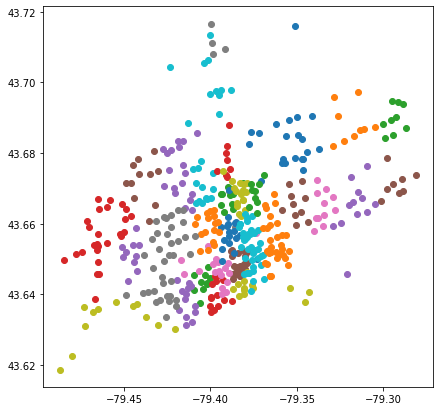

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 0
K1=40
5 Iterations...


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


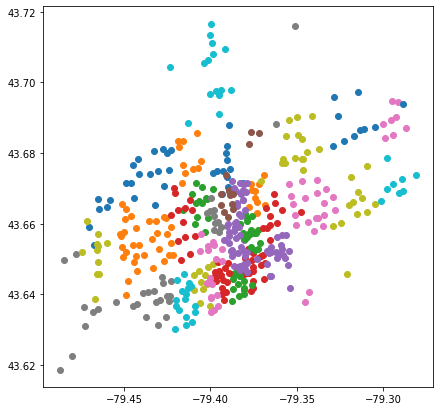

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 0


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


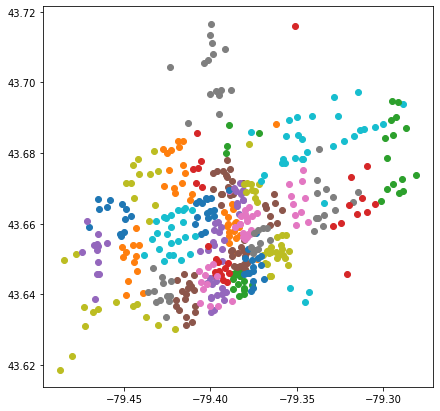

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 41


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


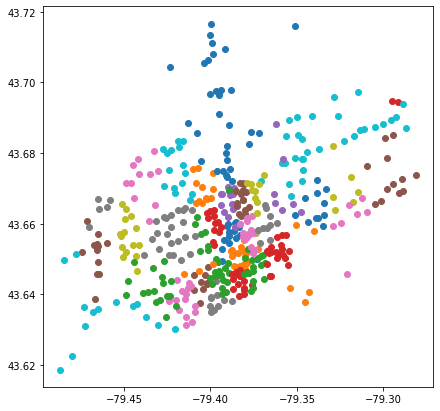

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 25


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


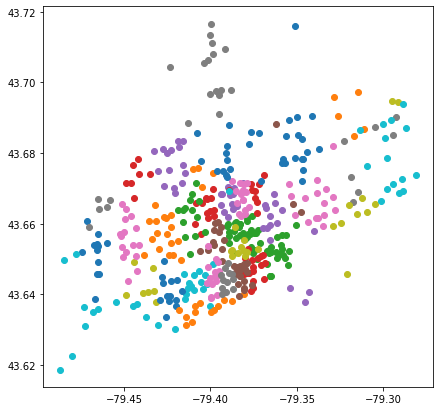

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 27


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


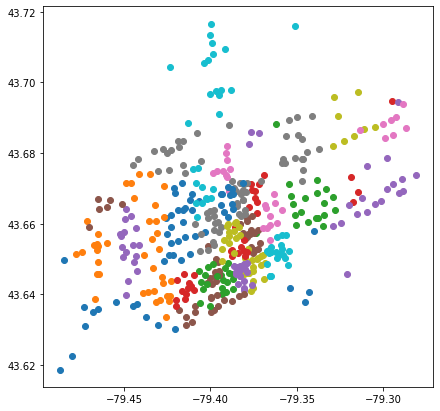

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 1
K1=38
10 Iterations...


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


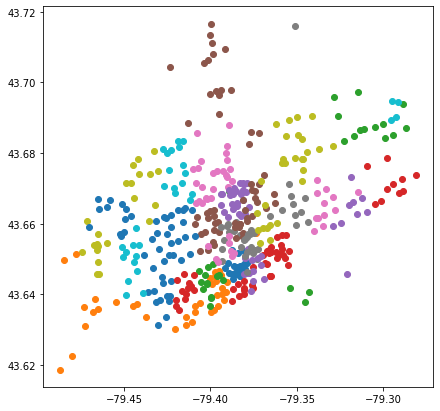

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 4


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


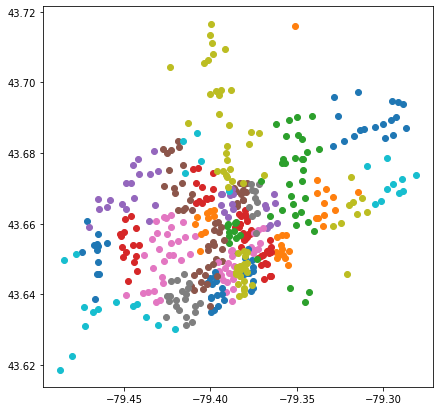

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 0


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


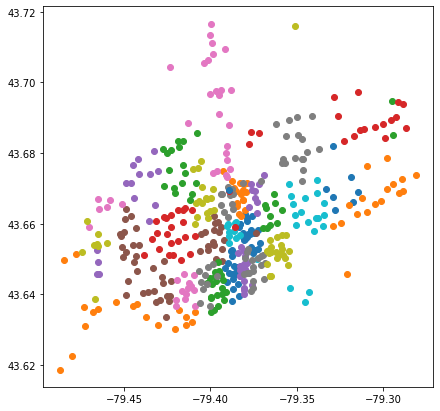

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 3


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


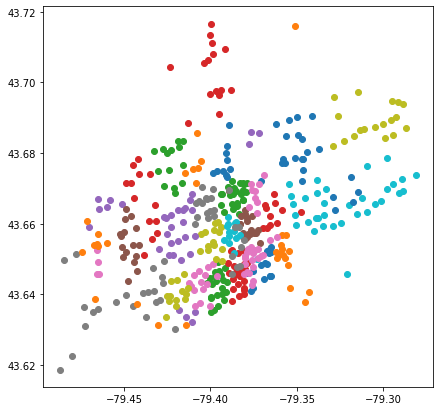

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 0


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


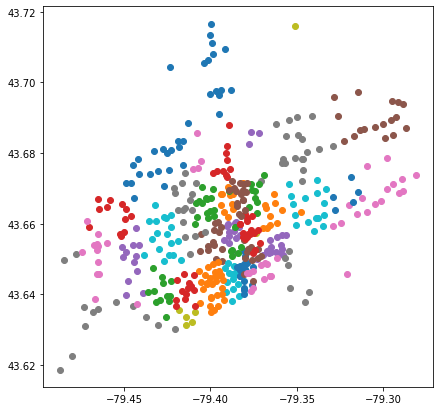

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 26


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


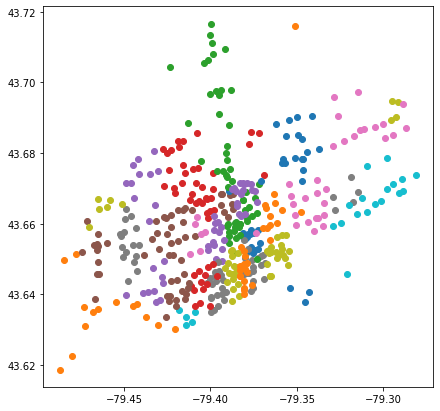

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 1


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


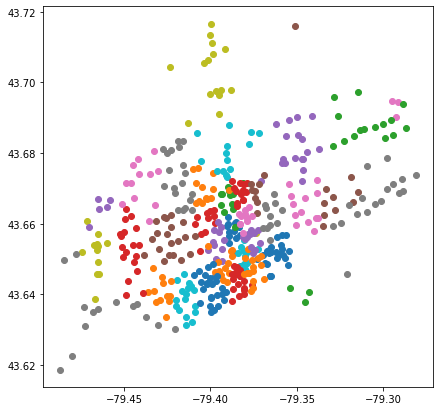

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 6


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


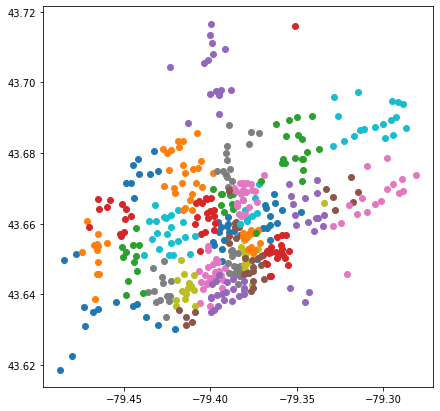

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 38


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


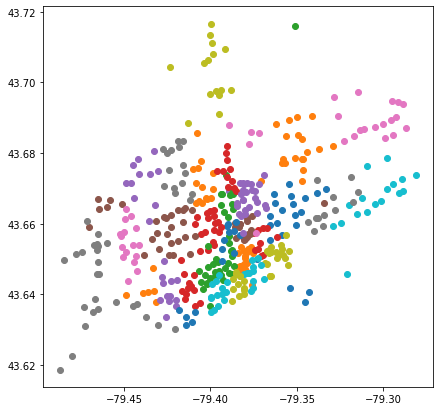

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 0


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


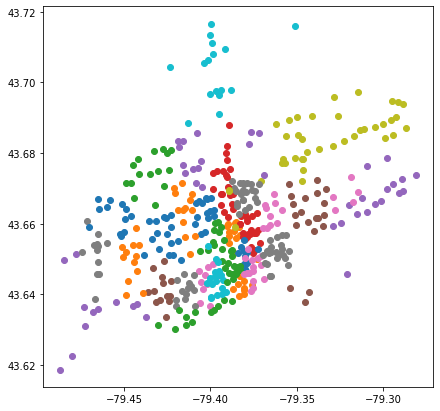

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 19
K1=39
15 Iterations...


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


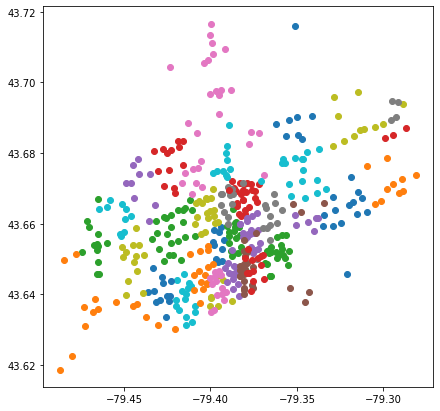

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 1


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


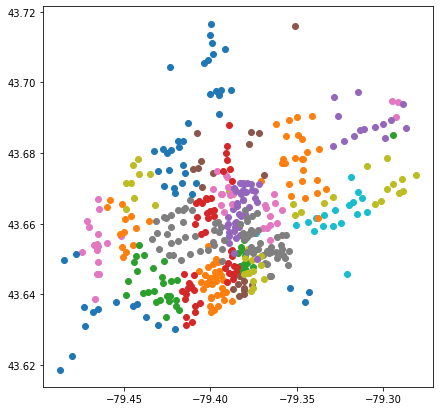

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 5


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


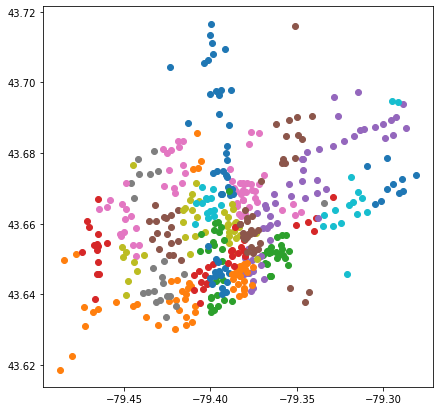

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 17


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


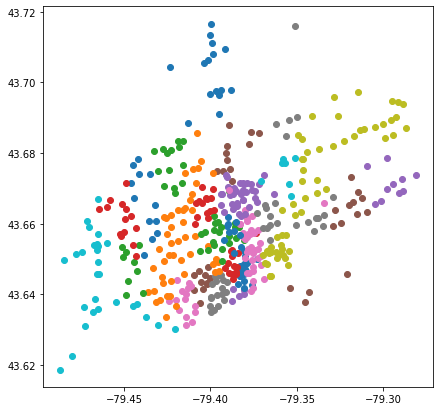

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 0


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


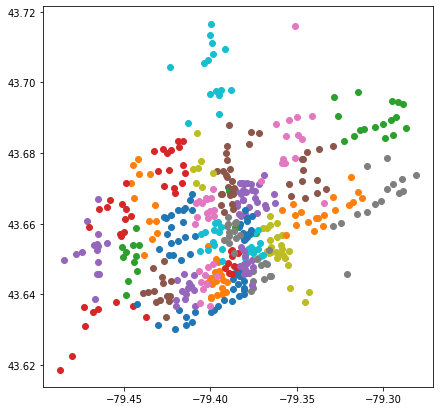

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 0


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


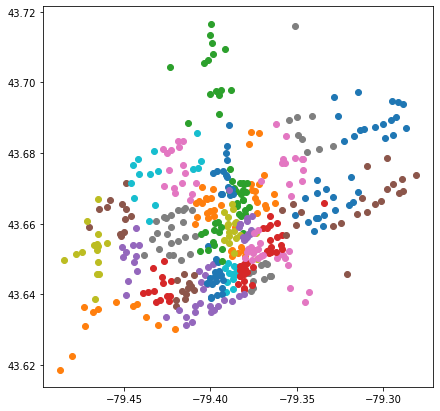

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 13


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


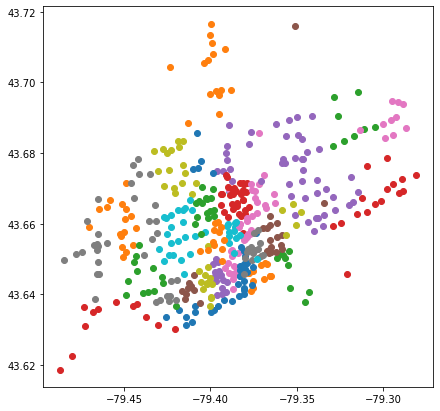

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 16


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


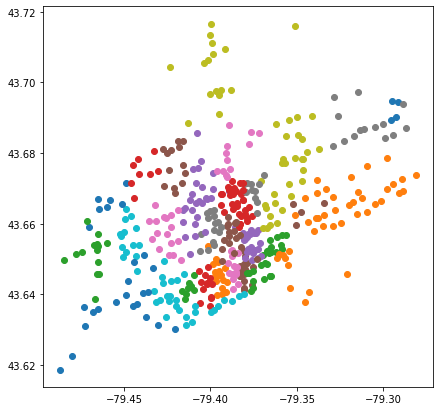

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 0


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


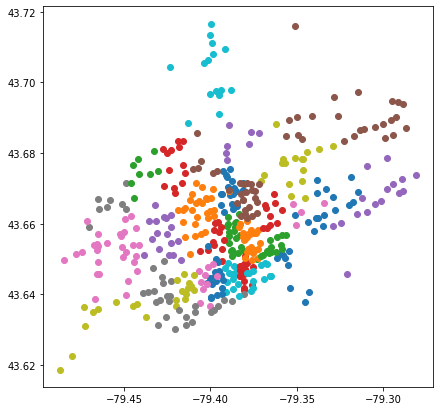

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 1


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


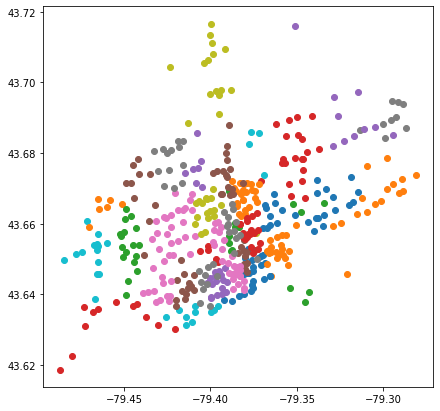

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 3


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


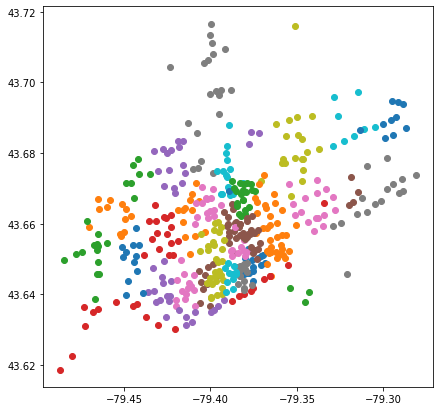

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 38


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


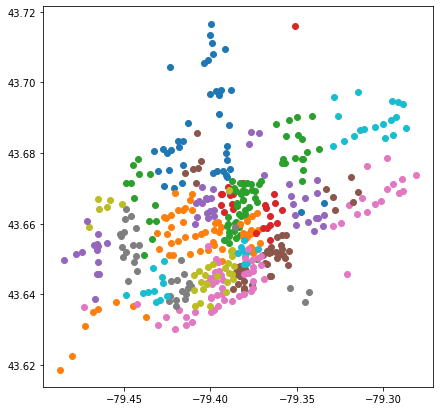

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 11


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


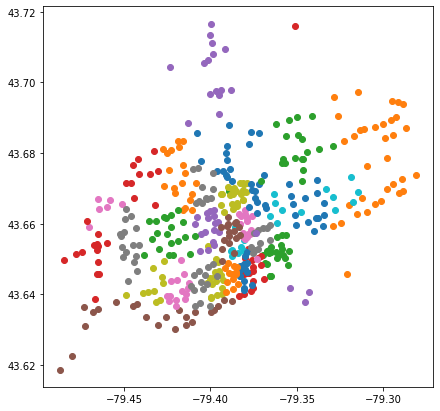

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 54


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


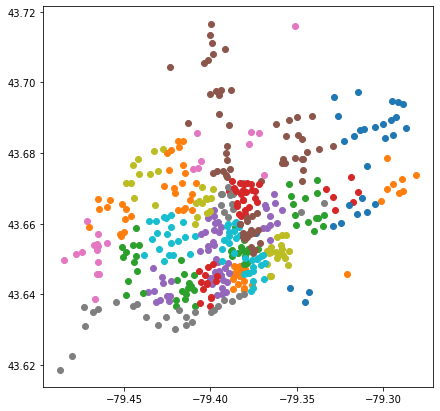

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 13


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


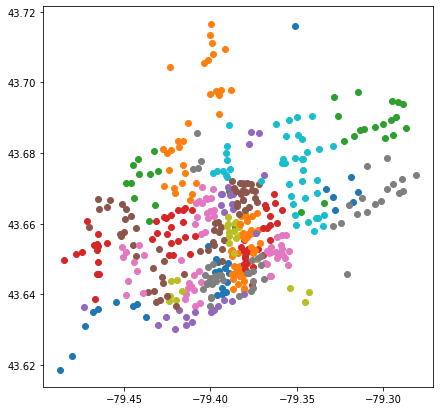

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 16
K1=38
20 Iterations...


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


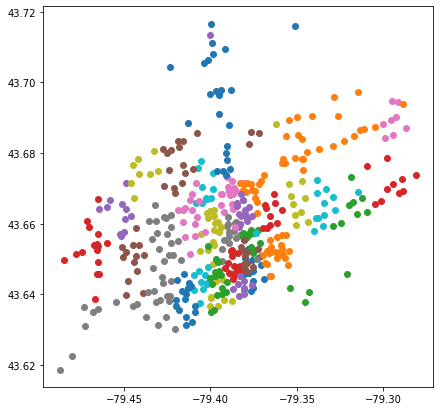

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 14


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


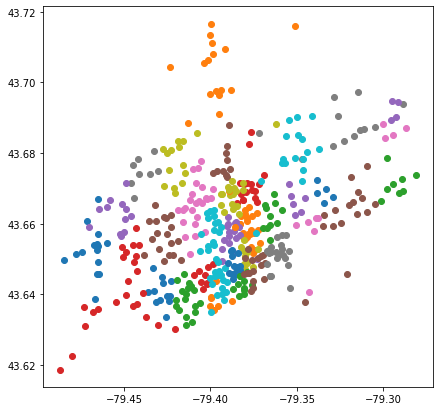

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 3


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


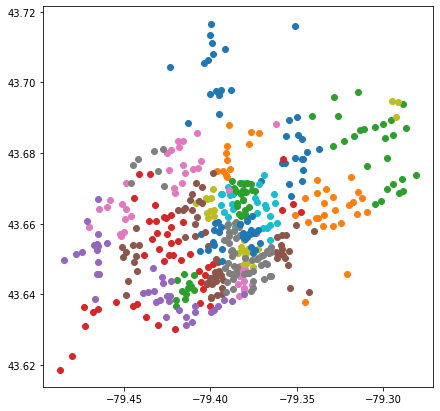

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 9


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


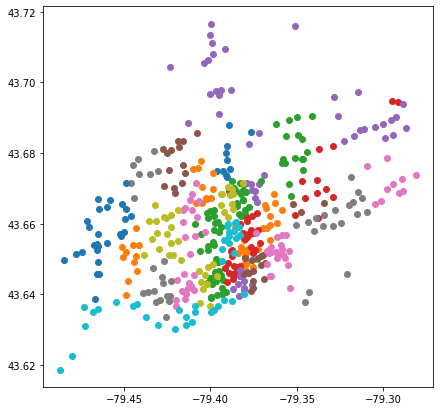

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 5


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


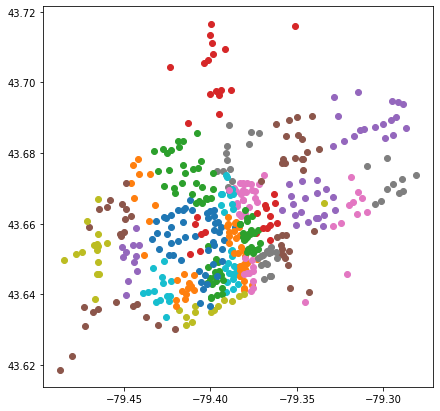

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 0


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


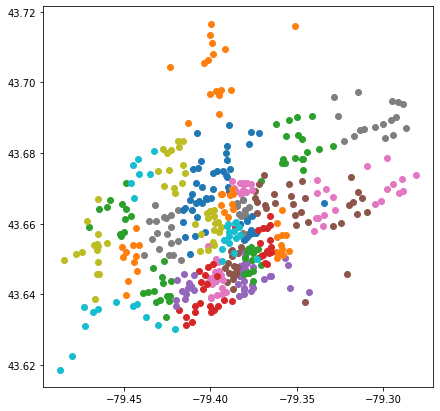

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 15


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


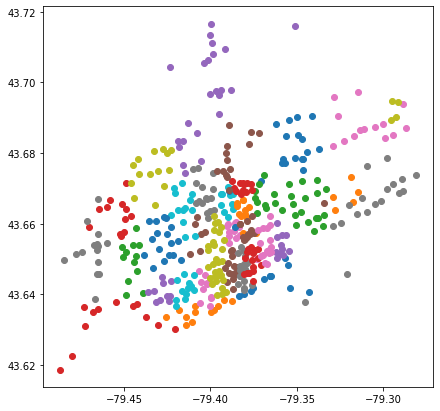

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 17


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


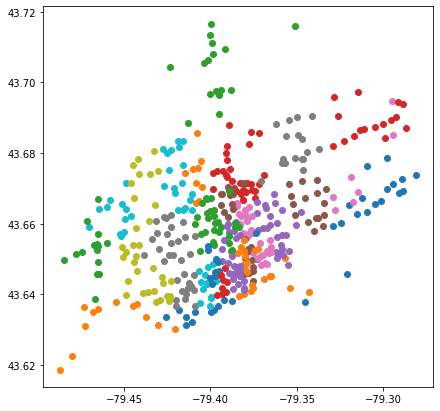

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 0


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


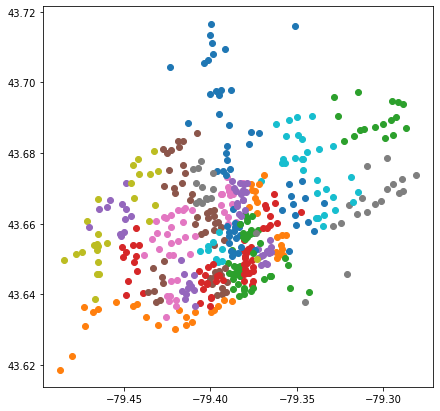

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 1


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


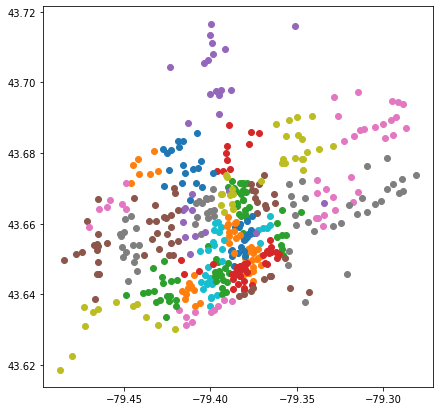

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 6


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


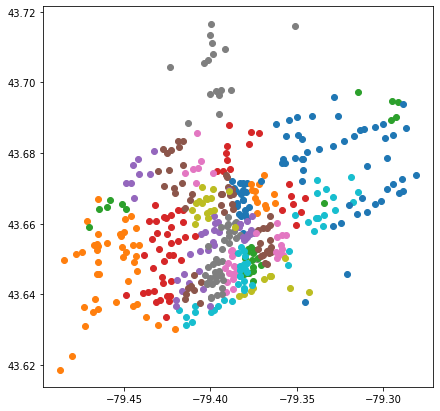

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 13


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


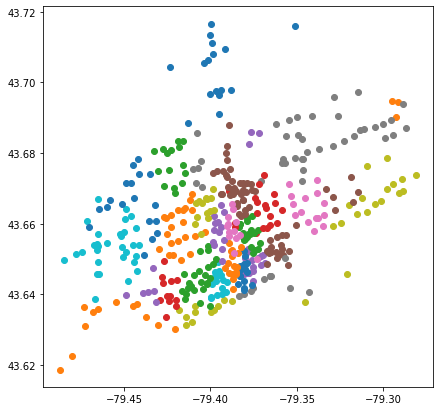

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 16


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


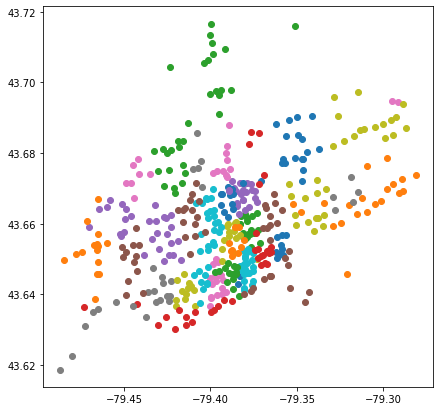

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 1


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


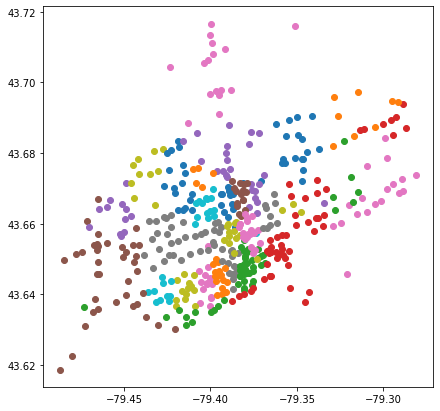

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 58


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


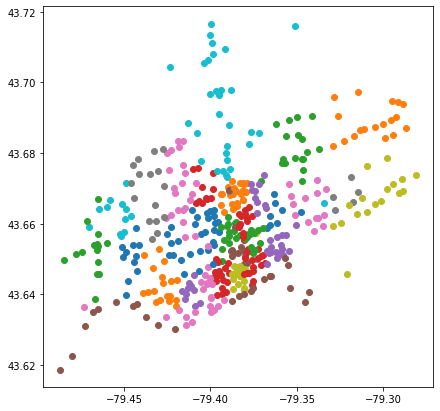

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 9


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


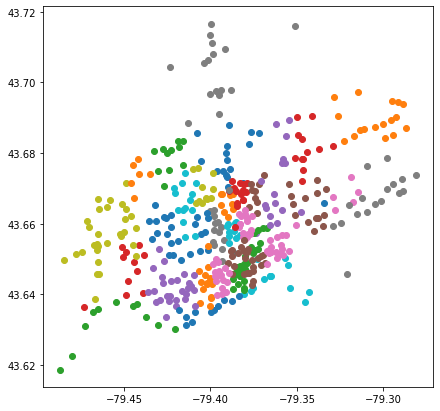

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 0


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


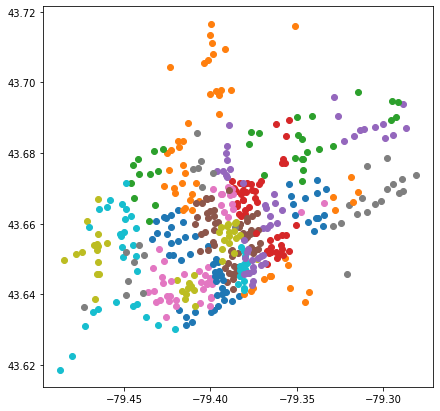

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 1


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


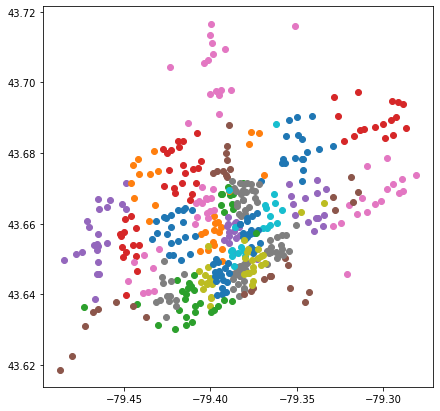

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 4


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


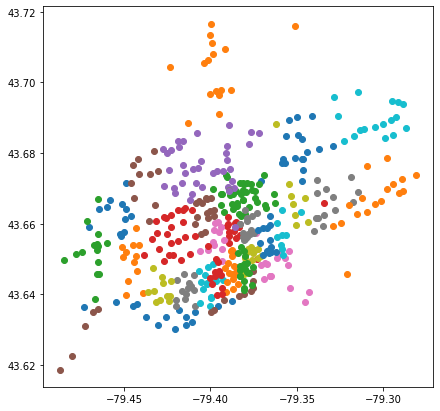

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


464 18


  0%|          | 0/464 [00:00<?, ?it/s]

(464, 304)


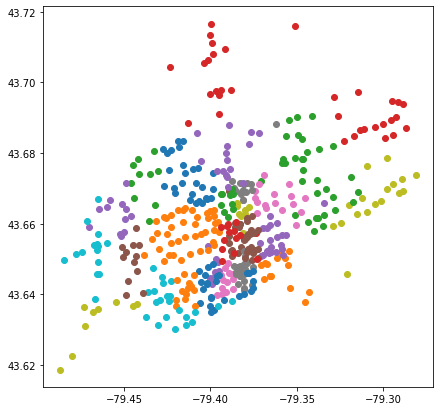

464 0
K1=35


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


In [17]:
nIterations_list = [1, 5, 10, 15, 20]
k2=16
for nIterations in nIterations_list:
  print("{} Iterations...".format(nIterations))
  station_data_w_clusters = bipartite_clustering(ridership_data=merged_data, station_data=df_station_assignments, K2=k2, W=nIterations)
  # print(station_data_w_clusters.head())
  station_data_w_clusters.to_csv('/content/drive/My Drive/MIE498 Thesis/Share-Bike-Station-Clustering-and-Usage-Prediction/station_data_w_clusters_{}iterations_k2={}.csv'.format(nIterations, k2))

In [ ]:
# station_data_w_clusters